Taking contiguous subset from index 106368 to 111368 (Total samples: 259835)
Using all samples (including silences). Total: 5000
Computing UMAP...


/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot to umap_poster_viz.png


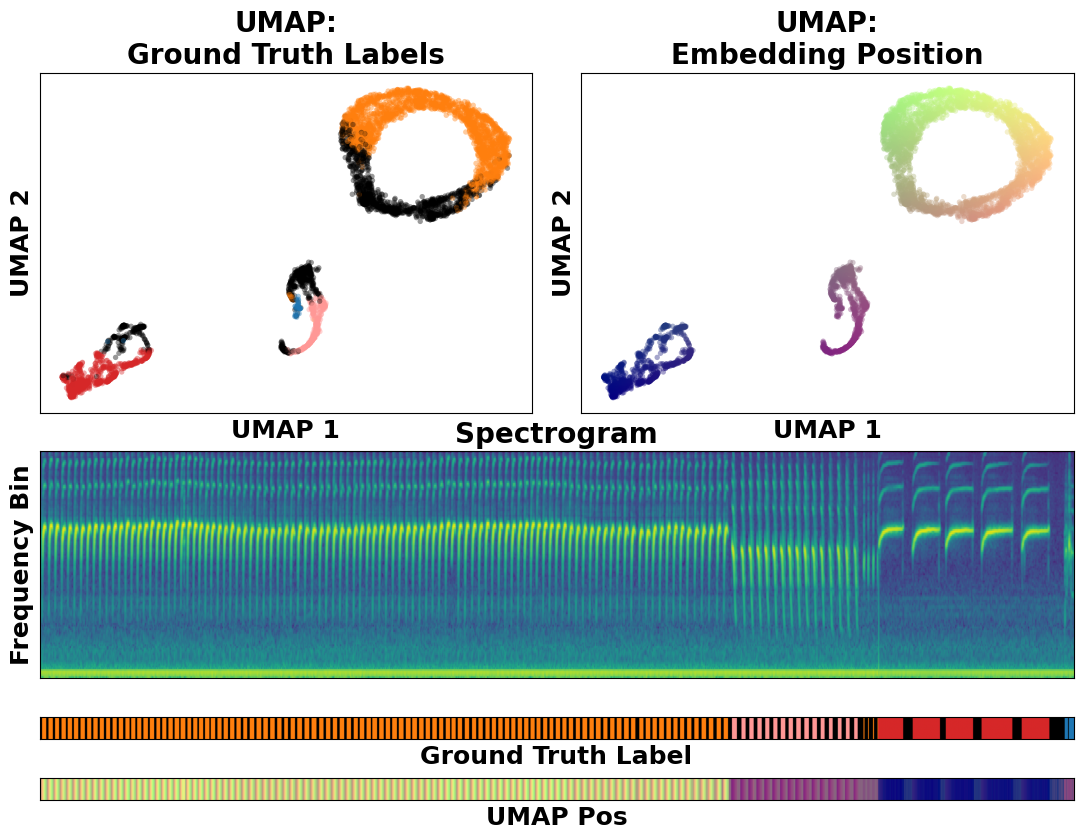

In [97]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Configuration ---
# Set font sizes for "poster ready" look
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 22
})

# Load data
embedding_path = "/Users/georgev/Documents/codebases/TinyBird/results/eval_experiments/tinybird_pretrain_20251122_091539_newer/canary/llb3_annot/embeddings.npz"

data = np.load(embedding_path)

emb = data["encoded_embeddings_after_pos_removal"]
labels = data["labels_downsampled"]
spectrogram = data["spectrograms"]

# Determine silence label
# Based on extract_embedding.py, silence is -1.
silence_label = -1

# Subset a random contiguous chunk of N samples
N = 5000 # Increased N to ensure enough data after silence removal
total_samples = emb.shape[0]
max_start = total_samples - N

if max_start > 0:
    start_idx = np.random.randint(0, max_start)
else:
    start_idx = 0

end_idx = start_idx + N
print(f"Taking contiguous subset from index {start_idx} to {end_idx} (Total samples: {total_samples})")

emb_subset = emb[start_idx:end_idx]
labels_subset = labels[start_idx:end_idx]
spec_subset = spectrogram[start_idx:end_idx]

# Keep all samples (including silences)
emb_filtered = emb_subset
labels_filtered = labels_subset
spec_filtered = spec_subset

print(f"Using all samples (including silences). Total: {len(labels_filtered)}")

# Compute UMAP
print("Computing UMAP...")
reducer = umap.UMAP(random_state=42, n_neighbors=100, min_dist=0.1, metric='cosine')
emb_umap = reducer.fit_transform(emb_filtered)

# --- Prepare Colors ---

# 1. Ground Truth Colors
# Logic: Label -1 (silence) -> Black. Label 0 and all other positive labels -> Tab20 colors
unique_labels = np.unique(labels_filtered)
cmap = plt.get_cmap('tab20') 

# Create color array
c_gt = np.zeros((len(labels_filtered), 4)) # RGBA

def get_label_color(lbl):
    if lbl == -1:
        return [0.0, 0.0, 0.0, 1.0] # Black for silence
    else:
        return cmap((lbl) % 20) # tab20 for all non-silence (including label 0)

for i, lbl in enumerate(labels_filtered):
    c_gt[i] = get_label_color(lbl)

# 2. Position Colors (Map 2D UMAP to RGB)
min_u = emb_umap.min(axis=0)
max_u = emb_umap.max(axis=0)
norm_umap = (emb_umap - min_u) / (max_u - min_u)

c_pos = np.zeros((len(labels_filtered), 3))
c_pos[:, 0] = norm_umap[:, 0] 
c_pos[:, 1] = norm_umap[:, 1]
c_pos[:, 2] = 0.5 

# --- Plotting ---
fig = plt.figure(figsize=(11, 8.875)) # 11 x 8.875 inches as requested
gs = gridspec.GridSpec(4, 2, height_ratios=[3, 2, 0.2, 0.2], hspace=0.25, wspace=0.1, left=0.05, right=0.99, top=0.88, bottom=0.06)

# 1. UMAP: Ground Truth Labels
ax_umap_gt = fig.add_subplot(gs[0, 0])
# No merging, just raw labels; alpha=0.4 for visual consistency
scatter_gt = ax_umap_gt.scatter(emb_umap[:, 0], emb_umap[:, 1], c=c_gt, s=15, alpha=0.4, edgecolors='none')
ax_umap_gt.set_title("UMAP:\nGround Truth Labels", fontweight='bold')

ax_umap_gt.set_xlabel("UMAP 1", fontweight='bold')
ax_umap_gt.set_ylabel("UMAP 2", fontweight='bold')
ax_umap_gt.set_xticks([])
ax_umap_gt.set_yticks([])

# 2. UMAP: Embedding colored (Position)
ax_umap_pos = fig.add_subplot(gs[0, 1])
scatter_pos = ax_umap_pos.scatter(emb_umap[:, 0], emb_umap[:, 1], c=c_pos, s=15, alpha=0.4, edgecolors='none')
ax_umap_pos.set_title("UMAP:\nEmbedding Position", fontweight='bold')
ax_umap_pos.set_xlabel("UMAP 1", fontweight='bold')
ax_umap_pos.set_ylabel("UMAP 2", fontweight='bold')
ax_umap_pos.set_xticks([])
ax_umap_pos.set_yticks([])

# 3. Spectrogram (Full with silences)
ax_spec = fig.add_subplot(gs[1, :])
ax_spec.imshow(spec_filtered.T, aspect='auto', origin='lower', cmap='viridis')
ax_spec.set_title("Spectrogram", fontweight='bold')
ax_spec.set_ylabel("Frequency Bin", fontweight='bold')
ax_spec.set_xticks([]) 
ax_spec.set_yticks([])
# Removed x-axis label "Time Bin Index" as per instruction

# 4. Color Bar: Ground Truth
ax_bar_gt = fig.add_subplot(gs[2, :])
ax_bar_gt.imshow(c_gt[np.newaxis, :, :], aspect='auto')
ax_bar_gt.set_xlabel("Ground Truth Label", fontweight='bold')
ax_bar_gt.set_yticks([])
ax_bar_gt.set_xticks([])

# 5. Color Bar: Position in UMAP
ax_bar_pos = fig.add_subplot(gs[3, :])
ax_bar_pos.imshow(c_pos[np.newaxis, :, :], aspect='auto')
ax_bar_pos.set_xlabel("UMAP Pos", fontweight='bold')
ax_bar_pos.set_yticks([])
ax_bar_pos.set_xticks([])

# plt.tight_layout()

# Save as PNG at HIGH DPI (600)
png_path = "umap_poster_viz.png"
plt.savefig(png_path, format='png', dpi=600)
print(f"Saved plot to {png_path}")

plt.show()